# Factor Analysis

Factor analysis is a method for automatically finding latent variables in a data set. It assumes that observed variables are actually a linear combination of a number of latent factors. Often, we are aiming to find a smaller number of factors that explain trends in our data.

This is how factor analysis differs from principal componant analysis. In PCA, the components are not interpretable, however, in factor analysis, we can see which observed variables are highly correlated with which factors and group observed variables according to which factors they are correlated with by looking at the loading. We can also see which factors are most important by their eiganvalues. Another technical difference between PCA and factor analysis is that in PCA, all the components are orthogonal but in factor analysis this does not need to be the case.

## Load Data

In [66]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import pointbiserialr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [67]:
np.random.seed(5151)
rpe_df = pd.read_csv('./raw_data/rpe.csv')
print(rpe_df.head())
print(len(rpe_df[(rpe_df['Training']=='No') & (rpe_df['FocusRating'].isnull())]))
print(len(rpe_df[(rpe_df['Training']=='No')]))

         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0        NaN        NaN          NaN                NaN   
2        243.0        NaN        NaN          NaN                NaN   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0        NaN        NaN          NaN                NaN   

   ObjectiveRating  FocusRating BestOutOfMyself  
0              NaN          NaN      Not at all  
1              NaN          NaN      Not at al

In [68]:
print(rpe_df.shape)

indexNames = rpe_df[ (rpe_df['PlayerID'] < 18) | (rpe_df['PlayerID'] > 21) ]
print(indexNames.shape)

(8860, 14)
(8860, 14)


To start with, we have 8860 observations.

## Cleaning Data

In [69]:
print(len(rpe_df) - rpe_df['Training'].count())
# rpe_df = rpe_df[~ rpe_df['SessionType'].isna()]
print(len(rpe_df))
print(rpe_df[rpe_df['SessionType'].isna()].shape)
print(rpe_df[rpe_df['Duration'].isna()].shape)
print(rpe_df[rpe_df['RPE'].isna()].shape)
print(rpe_df[rpe_df['SessionLoad'].isna()].shape)
print(rpe_df[rpe_df['DailyLoad'].isna()].shape)
print(rpe_df[rpe_df['AcuteLoad'].isna()].shape)
print(rpe_df[rpe_df['ChronicLoad'].isna()].shape)

print(rpe_df[rpe_df['DailyLoad'].isna()].shape)
print(rpe_df[rpe_df['AcuteLoad'].isna()].shape)
print(rpe_df[rpe_df['ChronicLoad'].isna()].shape)
print(rpe_df.head())

0
8860
(1239, 14)
(1239, 14)
(1239, 14)
(1239, 14)
(5711, 14)
(4511, 14)
(4477, 14)
(5711, 14)
(4511, 14)
(4477, 14)
         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0        NaN        NaN          NaN                NaN   
2        243.0        NaN        NaN          NaN                NaN   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0        NaN        NaN          NaN                NaN   

   ObjectiveRating  FocusRati

In [70]:
# For datapoints that did do a training but their ratings are nan generate random ratqings
# based on the current distribution of the values
for s in ['ObjectiveRating', 'FocusRating', 'BestOutOfMyself']:

    isnull = (rpe_df['Training']=='Yes') & (rpe_df[s].isnull())
    sample = rpe_df[(rpe_df['Training']=='Yes')][s].dropna().sample(isnull.sum(), replace=True).values
    rpe_df.loc[isnull, s] = sample
print(rpe_df.head())

         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0        NaN        NaN          NaN                NaN   
2        243.0        NaN        NaN          NaN                NaN   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0        NaN        NaN          NaN                NaN   

   ObjectiveRating  FocusRating BestOutOfMyself  
0              0.0          8.0      Not at all  
1              8.0         10.0      Not at al

In [71]:
rpe_df['BestOutOfMyself'].value_counts()

Absolutely    6548
Not at all    1072
Somewhat       535
Name: BestOutOfMyself, dtype: int64

In [72]:
print(rpe_df.head())
rpe_df['BestOutOfMyself'] = rpe_df['BestOutOfMyself'].map({'Absolutely': 3, 'Not at all': 0, 'Somewhat': 1})
print(rpe_df.head())

         Date  PlayerID Training        SessionType  Duration  RPE  \
0  2018-07-21        13      Yes  Mobility/Recovery       5.0  0.0   
1  2018-07-21        13      Yes               Game      29.0  7.0   
2  2018-07-21        13      Yes               Game      27.0  9.0   
3  2018-07-20        11      Yes               Game      36.0  6.0   
4  2018-07-20        11      Yes               Game      36.0  8.0   

   SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
0          0.0      446.0      323.1       303.25               1.07   
1        203.0        NaN        NaN          NaN                NaN   
2        243.0        NaN        NaN          NaN                NaN   
3        216.0      534.0      256.3       344.18               0.74   
4        288.0        NaN        NaN          NaN                NaN   

   ObjectiveRating  FocusRating BestOutOfMyself  
0              0.0          8.0      Not at all  
1              8.0         10.0      Not at al

## Factor Analysis

In [73]:
print(len(rpe_df),len(rpe_df[rpe_df['BestOutOfMyself'].isnull()]))
rpe_df['SessionType'].value_counts()
rpe_df['Training'] = rpe_df['Training'].map({'Yes': 1, 'No': 0})
rpe_df[rpe_df['PlayerID'] == 1]

8860 705


,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
9,2018-07-19,1,1,Skills,60.0,3.0,180.0,180.0,87.9,140.54,0.63,9.0,8.0,0.0
20,2018-07-18,1,0,NaN,NaN,NaN,NaN,NaN,62.1,159.46,0.39,NaN,NaN,NaN
29,2018-07-17,1,1,Skills,60.0,3.0,180.0,195.0,62.1,173.93,0.36,9.0,9.0,3.0
30,2018-07-17,1,1,Mobility/Recovery,30.0,0.0,15.0,NaN,NaN,NaN,NaN,9.0,8.0,3.0
47,2018-07-16,1,1,Skills,60.0,3.0,180.0,240.0,34.3,166.96,0.21,8.0,8.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8719,2017-08-07,1,1,Skills,60.0,3.0,180.0,NaN,NaN,NaN,NaN,7.0,8.0,0.0
8801,2017-08-03,1,0,NaN,NaN,NaN,NaN,NaN,77.1,19.29,4.00,NaN,NaN,1.0
8828,2017-08-02,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
8841,2017-08-01,1,1,Speed,60.0,3.0,180.0,540.0,77.1,19.29,4.00,0.0,0.0,3.0


Now we need to recompute sessionloads (since previous session loads were sometimes miscalculated) and consecutively recompute daily loads chronic loads and acute loads for both cases were a player had a training or not. 

In [74]:
rpe_df['SessionLoad'] = rpe_df['Duration'] * rpe_df['RPE']

rpe_df.Date = pd.to_datetime(rpe_df.Date)
rpe_df = rpe_df.sort_values(by = 'Date', ascending = True)
print(rpe_df.head())
# Recomputing DailyLoad
rpe_df['DailyLoad'] = rpe_df.groupby(['Date','PlayerID'])['SessionLoad'].transform('sum')
rpe_df[rpe_df['Date'] == '2017-09-06']

           Date  PlayerID  Training SessionType  Duration  RPE  SessionLoad  \
8859 2017-08-01        15         1    Strength      60.0  4.0        240.0   
8841 2017-08-01         1         1       Speed      60.0  3.0        180.0   
8842 2017-08-01         1         1    Strength      90.0  4.0        360.0   
8843 2017-08-01         3         1       Speed      45.0  5.0        225.0   
8844 2017-08-01         3         1    Strength      90.0  5.0        450.0   

      DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  ObjectiveRating  \
8859        NaN        NaN          NaN                NaN              6.0   
8841      540.0       77.1        19.29                4.0              0.0   
8842        NaN        NaN          NaN                NaN              0.0   
8843      675.0       96.4        24.11                4.0              7.0   
8844        NaN        NaN          NaN                NaN              7.0   

      FocusRating  BestOutOfMyself  
8859         

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
7911,2017-09-06,8,1,Mobility/Recovery,60.0,0.0,0.0,0.0,527.1,560.89,0.94,9.0,8.0,3.0
7906,2017-09-06,1,1,Mobility/Recovery,45.0,0.0,0.0,0.0,316.0,335.39,0.94,8.0,9.0,3.0
7907,2017-09-06,2,1,Mobility/Recovery,45.0,1.0,45.0,45.0,257.1,296.96,0.87,8.0,9.0,3.0
7908,2017-09-06,3,1,Mobility/Recovery,60.0,3.0,180.0,270.0,432.1,589.64,0.73,8.0,8.0,3.0
7909,2017-09-06,3,1,Mobility/Recovery,30.0,3.0,90.0,270.0,NaN,NaN,NaN,8.0,8.0,3.0
7912,2017-09-06,9,1,Strength,90.0,5.0,450.0,720.0,402.1,312.50,1.29,9.0,9.0,3.0
7910,2017-09-06,7,1,Mobility/Recovery,45.0,1.0,45.0,45.0,452.4,542.21,0.83,9.0,7.0,3.0
7914,2017-09-06,10,1,Mobility/Recovery,45.0,0.0,0.0,0.0,232.7,321.04,0.72,0.0,0.0,3.0
7915,2017-09-06,11,1,Mobility/Recovery,60.0,2.0,120.0,180.0,454.3,561.96,0.81,10.0,10.0,3.0
7916,2017-09-06,11,1,Mobility/Recovery,60.0,1.0,60.0,180.0,NaN,NaN,NaN,10.0,10.0,3.0


In [75]:
rpe_df['DailyLoad'] = rpe_df.groupby(['Date','PlayerID'])['DailyLoad'].fillna(method='ffill')

In [76]:
temp = rpe_df[['Date','PlayerID','DailyLoad']].drop_duplicates()
past7Days = temp.groupby('PlayerID').rolling('7d', on='Date')['DailyLoad'].sum().reset_index()
past7Days['newAcuteLoad'] = (past7Days['DailyLoad'] / 7.).round(2)
past7Days = past7Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past7Days, how="left", on=["Date", "PlayerID"])

In [77]:
past30Days = temp.groupby('PlayerID').rolling('30d', on='Date')['DailyLoad'].sum().reset_index()
past30Days['newChronicLoad'] = (past30Days['DailyLoad'] / 30.).round(2)
past30Days = past30Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past30Days, how="left", on=["Date", "PlayerID"])
print(rpe_df[rpe_df['PlayerID'] == 1])

           Date  PlayerID  Training        SessionType  Duration  RPE  \
1    2017-08-01         1         1              Speed      60.0  3.0   
2    2017-08-01         1         1           Strength      90.0  4.0   
19   2017-08-02         1         0                NaN       NaN  NaN   
41   2017-08-03         1         0                NaN       NaN  NaN   
114  2017-08-07         1         1             Skills      60.0  3.0   
...         ...       ...       ...                ...       ...  ...   
8797 2018-07-16         1         1              Speed      30.0  2.0   
8814 2018-07-17         1         1             Skills      60.0  3.0   
8815 2018-07-17         1         1  Mobility/Recovery      30.0  0.0   
8832 2018-07-18         1         0                NaN       NaN  NaN   
8840 2018-07-19         1         1             Skills      60.0  3.0   

      SessionLoad  DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  \
1           180.0      540.0       77.1        1

In [78]:
rpe_df.drop(['ChronicLoad','AcuteLoad'],axis = 1, inplace = True)
rpe_df.rename(columns = {'newChronicLoad':'ChronicLoad','newAcuteLoad':'AcuteLoad'}, inplace = True)
rpe_df['AcuteChronicRatio'] = (rpe_df['AcuteLoad'] / rpe_df['ChronicLoad']).round(2)
print(rpe_df[rpe_df['PlayerID'] == 1])

           Date  PlayerID  Training        SessionType  Duration  RPE  \
1    2017-08-01         1         1              Speed      60.0  3.0   
2    2017-08-01         1         1           Strength      90.0  4.0   
19   2017-08-02         1         0                NaN       NaN  NaN   
41   2017-08-03         1         0                NaN       NaN  NaN   
114  2017-08-07         1         1             Skills      60.0  3.0   
...         ...       ...       ...                ...       ...  ...   
8797 2018-07-16         1         1              Speed      30.0  2.0   
8814 2018-07-17         1         1             Skills      60.0  3.0   
8815 2018-07-17         1         1  Mobility/Recovery      30.0  0.0   
8832 2018-07-18         1         0                NaN       NaN  NaN   
8840 2018-07-19         1         1             Skills      60.0  3.0   

      SessionLoad  DailyLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
1           180.0      540.0              

In [79]:
print(len(rpe_df))
rpe_df.to_csv('./processed_data/processed_rpe.csv')
#.drop(['Training'], axis=1)
training_yes = rpe_df[rpe_df['Training'] == 1].drop(['Training'], axis=1)
training_no = rpe_df[rpe_df['Training'] == 0].drop(['Training'], axis=1)
print(len(training_yes))

8860
7622


In [80]:
print(len(training_no),len(training_no[training_no['SessionType'].isnull()]))
print(training_no['SessionType'].value_counts())
print(training_no[training_no['SessionType']=='Conditioning'])
print(training_no['Duration'].value_counts())
print(training_no['RPE'].value_counts())
print(training_no['SessionLoad'].value_counts())
print(training_no['DailyLoad'].value_counts())
print(training_no['AcuteLoad'].value_counts())
print(training_no['ChronicLoad'].value_counts())
print(training_no['AcuteChronicRatio'].value_counts())
print(training_no['ObjectiveRating'].value_counts())
print(training_no['FocusRating'].value_counts())
print(training_no['BestOutOfMyself'].value_counts())

1238 1237
Conditioning    1
Name: SessionType, dtype: int64
           Date  PlayerID   SessionType  Duration  RPE  SessionLoad  \
3241 2017-11-30         3  Conditioning      30.0  5.0        150.0   

      DailyLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
3241     1180.0                0.9              8.0          8.0   

      BestOutOfMyself  AcuteLoad  ChronicLoad  
3241              3.0     407.86       454.67  
30.0    1
Name: Duration, dtype: int64
5.0    1
Name: RPE, dtype: int64
150.0    1
Name: SessionLoad, dtype: int64
0.0       1222
330.0        2
180.0        2
1180.0       1
990.0        1
210.0        1
615.0        1
1260.0       1
525.0        1
225.0        1
1245.0       1
770.0        1
98.0         1
90.0         1
560.0        1
Name: DailyLoad, dtype: int64
0.00      17
278.57     8
488.57     8
162.86     8
51.43      8
          ..
162.43     1
192.86     1
291.14     1
635.71     1
260.00     1
Name: AcuteLoad, Length: 628, dtype: int64
292.00  

There was only one datapoint that by mistake the training field was marked as a No, while it was a conditioning training. So we add that to the training_yes group and remove it from the training_no group. Also since there were only 5 datapoints that had focus rating and objective rating we can remove these two columns from the training_no group.

We need to recalculate session loads and consecutively acuteloads and training loads, as they were miscalculated in some cases.

In [81]:
print(len(training_yes))
tmp_df = training_no[training_no['SessionType']=='Conditioning']
training_yes = pd.concat([training_yes, tmp_df])
print(len(training_yes))
print(len(training_no))
training_no = training_no[training_no['SessionType'].isnull()]
print(len(training_no))

7622
7623
1238
1237


In [82]:
# Removing rows that had dailyloads (since it means they did do
# trainings on that day after all and there are only 13 of them)
training_no = training_no[training_no['DailyLoad'] == 0]
print(len(training_no))

1222


In [83]:
print(len(training_no),training_no.columns)
training_no.dropna(axis = 1, how = 'all',inplace = True)
training_no.drop(['ObjectiveRating', 'FocusRating','DailyLoad'],axis=1, inplace = True)
print(training_no.columns)

1222 Index(['Date', 'PlayerID', 'SessionType', 'Duration', 'RPE', 'SessionLoad',
       'DailyLoad', 'AcuteChronicRatio', 'ObjectiveRating', 'FocusRating',
       'BestOutOfMyself', 'AcuteLoad', 'ChronicLoad'],
      dtype='object')
Index(['Date', 'PlayerID', 'AcuteChronicRatio', 'BestOutOfMyself', 'AcuteLoad',
       'ChronicLoad'],
      dtype='object')


In [84]:
import pingouin as pg
test_training =  training_yes.copy()
print(test_training['SessionType'].unique())
test_training['SessionType'] = test_training['SessionType'].map({'Combat': 0, 'Conditioning': 1,
                                                                 'Game': 2,
                                                                 'Mobility/Recovery': 3,
                                                                 'Skills': 4,
                                                                 'Speed': 5,'Strength': 6})

['Strength' 'Speed' 'Conditioning' 'Skills' 'Mobility/Recovery' 'Game'
 'Combat' nan]


In [85]:

print(test_training.head(),test_training['SessionType'].unique())
for i in test_training.columns:
    if i == 'Date' or i == 'PlayerID':
        continue
        
    for j in test_training.columns:
        if j == 'Date' or j == 'PlayerID' or i == j:
            continue
            
        print('Repeated Measures Correlation Result for {} and {}'.format(i, j))
        print(pg.rm_corr(data=test_training, x=i, y=j, subject='PlayerID'))

        Date  PlayerID  SessionType  Duration  RPE  SessionLoad  DailyLoad  \
0 2017-08-01        15          6.0      60.0  4.0        240.0      300.0   
1 2017-08-01         1          5.0      60.0  3.0        180.0      540.0   
2 2017-08-01         1          6.0      90.0  4.0        360.0      540.0   
3 2017-08-01         3          5.0      45.0  5.0        225.0      675.0   
4 2017-08-01         3          6.0      90.0  5.0        450.0      675.0   

   AcuteChronicRatio  ObjectiveRating  FocusRating  BestOutOfMyself  \
0               4.29              6.0          7.0              3.0   
1               4.29              0.0          0.0              3.0   
2               4.29              0.0          0.0              3.0   
3               4.29              7.0          7.0              3.0   
4               4.29              7.0          7.0              3.0   

   AcuteLoad  ChronicLoad  
0      42.86         10.0  
1      77.14         18.0  
2      77.14        

             r   dof           pval        CI95%  power
rm_corr  0.377  7603  3.276575e-255  [0.36, 0.4]    1.0
Repeated Measures Correlation Result for DailyLoad and RPE
             r   dof           pval         CI95%  power
rm_corr  0.392  7603  1.496644e-277  [0.37, 0.41]    1.0
Repeated Measures Correlation Result for DailyLoad and SessionLoad
             r   dof  pval         CI95%  power
rm_corr  0.505  7603   0.0  [0.49, 0.52]    1.0
Repeated Measures Correlation Result for DailyLoad and AcuteChronicRatio
             r   dof          pval         CI95%  power
rm_corr  0.213  7605  8.002747e-79  [0.19, 0.23]    1.0
Repeated Measures Correlation Result for DailyLoad and ObjectiveRating
             r   dof      pval           CI95%  power
rm_corr -0.036  7605  0.001566  [-0.06, -0.01]  0.885
Repeated Measures Correlation Result for DailyLoad and FocusRating
             r   dof      pval         CI95%  power
rm_corr -0.019  7605  0.092882  [-0.04, 0.0]   0.39
Repeated Measures

             r   dof          pval         CI95%  power
rm_corr  0.063  7605  3.077089e-08  [0.04, 0.09]    1.0
Repeated Measures Correlation Result for AcuteLoad and SessionType
             r   dof          pval         CI95%  power
rm_corr  0.064  7603  2.776778e-08  [0.04, 0.09]    1.0
Repeated Measures Correlation Result for AcuteLoad and Duration
             r   dof          pval         CI95%  power
rm_corr  0.235  7603  9.462059e-96  [0.21, 0.26]    1.0
Repeated Measures Correlation Result for AcuteLoad and RPE
             r   dof          pval         CI95%  power
rm_corr  0.131  7603  1.994479e-30  [0.11, 0.15]    1.0
Repeated Measures Correlation Result for AcuteLoad and SessionLoad
             r   dof           pval         CI95%  power
rm_corr  0.252  7603  1.192362e-110  [0.23, 0.27]    1.0
Repeated Measures Correlation Result for AcuteLoad and DailyLoad
             r   dof  pval        CI95%  power
rm_corr  0.487  7605   0.0  [0.47, 0.5]    1.0
Repeated Measures Corr

In [ ]:
Repeated Measures Correlation Result for SessionType and Duration
             r   dof           pval         CI95%  power
rm_corr  0.414  7603  3.220236e-312  [0.39, 0.43]    1.0

Repeated Measures Correlation Result for Duration and SessionLoad
             r   dof  pval         CI95%  power
rm_corr  0.803  7603   0.0  [0.79, 0.81]    1.0
Repeated Measures Correlation Result for Duration and DailyLoad
             r   dof           pval        CI95%  power
rm_corr  0.377  7603  3.276575e-255  [0.36, 0.4]    1.0
Repeated Measures Correlation Result for RPE and SessionLoad
             r   dof  pval         CI95%  power
rm_corr  0.704  7603   0.0  [0.69, 0.72]    1.0
Repeated Measures Correlation Result for RPE and DailyLoad
             r   dof           pval         CI95%  power
rm_corr  0.392  7603  1.496658e-277  [0.37, 0.41]    1.0
Repeated Measures Correlation Result for SessionLoad and DailyLoad
             r   dof  pval         CI95%  power
rm_corr  0.505  7603   0.0  [0.49, 0.52]    1.0
Repeated Measures Correlation Result for DailyLoad and AcuteLoad
             r   dof  pval        CI95%  power
rm_corr  0.487  7605   0.0  [0.47, 0.5]    1.0
Repeated Measures Correlation Result for AcuteChronicRatio and ChronicLoad
             r   dof  pval          CI95%  power
rm_corr -0.478  7605   0.0  [-0.5, -0.46]    1.0
Repeated Measures Correlation Result for AcuteLoad and AcuteChronicRatio
            r   dof           pval         CI95%  power
rm_corr  0.34  7605  1.025404e-204  [0.32, 0.36]    1.0
Repeated Measures Correlation Result for ObjectiveRating and FocusRating
             r   dof           pval         CI95%  power
rm_corr  0.338  7605  3.670989e-203  [0.32, 0.36]    1.0
Repeated Measures Correlation Result for AcuteLoad and ChronicLoad
             r   dof  pval         CI95%  power
rm_corr  0.491  7605   0.0  [0.47, 0.51]    1.0

In [19]:
training_yes = pd.get_dummies( training_yes, columns = ['SessionType'] )
print(len(training_yes),training_yes.head())

7623         Date  PlayerID  Duration  RPE  SessionLoad  DailyLoad  \
0 2017-08-01        15      60.0  4.0        240.0      300.0   
1 2017-08-01         1      60.0  3.0        180.0      540.0   
2 2017-08-01         1      90.0  4.0        360.0      540.0   
3 2017-08-01         3      45.0  5.0        225.0      675.0   
4 2017-08-01         3      90.0  5.0        450.0      675.0   

   AcuteChronicRatio  ObjectiveRating  FocusRating  BestOutOfMyself  \
0               4.29              6.0          7.0              3.0   
1               4.29              0.0          0.0              3.0   
2               4.29              0.0          0.0              3.0   
3               4.29              7.0          7.0              3.0   
4               4.29              7.0          7.0              3.0   

   AcuteLoad  ChronicLoad  SessionType_Combat  SessionType_Conditioning  \
0      42.86         10.0                   0                         0   
1      77.14         18.0  

### Adequacy Tests

Before we perform any partiular tests for suitability, we should make sure there are not any columns that are correlated in our dataset.

In [20]:
training_no.to_csv('./processed_data/training_no.csv')
training_yes.to_csv('./processed_data/training_yes.csv')
print(training_no.head())
print(training_yes.corr())
print(training_no.corr())

         Date  PlayerID  AcuteChronicRatio  BestOutOfMyself  AcuteLoad  \
19 2017-08-02         1               4.29              NaN      77.14   
23 2017-08-02         9               4.29              NaN      57.86   
24 2017-08-02         5               4.29              NaN      47.14   
41 2017-08-03         1               4.29              1.0      77.14   
79 2017-08-04        11               4.28              3.0      80.00   

    ChronicLoad  
19        18.00  
23        13.50  
24        11.00  
41        18.00  
79        18.67  
                               PlayerID  Duration       RPE  SessionLoad  \
PlayerID                       1.000000 -0.067921 -0.085777    -0.102632   
Duration                      -0.067921  1.000000  0.254596     0.798762   
RPE                           -0.085777  0.254596  1.000000     0.708918   
SessionLoad                   -0.102632  0.798762  0.708918     1.000000   
DailyLoad                     -0.059594  0.370030  0.404642     0.5

In [21]:
player_data_yes = training_yes.groupby('PlayerID',as_index = False).mean()
print(player_data_yes.head())
player_id_series = player_data_yes['PlayerID']
new_df_yes = player_data_yes.drop(['PlayerID'], axis=1)
print(new_df_yes.corr())
chi_square_value,p_value = calculate_bartlett_sphericity(new_df_yes)
print(chi_square_value, p_value)

yes_without_session_type = new_df_yes.drop(['SessionType_Combat',
                                        'SessionType_Conditioning',
                                       'SessionType_Game',
                                       'SessionType_Mobility/Recovery',
                                       'SessionType_Skills',
                                       'SessionType_Speed',
                                       'SessionType_Strength'],axis=1)
print(yes_without_session_type.columns)

kmo_all,kmo_model=calculate_kmo(yes_without_session_type)
print(kmo_all, kmo_model)

   PlayerID   Duration       RPE  SessionLoad   DailyLoad  AcuteChronicRatio  \
0         1  62.807203  3.476695   247.175847  667.213983           1.141208   
1         2  51.758621  4.241379   236.977688  724.131313           1.258909   
2         3  58.376569  4.995816   300.866109  783.217573           1.253975   
3         4  63.384804  4.497549   295.147059  727.541667           1.242892   
4         5  56.828571  4.281633   253.873469  666.591837           1.387388   

   ObjectiveRating  FocusRating  BestOutOfMyself   AcuteLoad  ChronicLoad  \
0         8.031780     8.218220         2.567797  371.749788   345.053305   
1         8.046465     8.149495         2.462626  390.753374   339.576566   
2         8.033473     7.981172         2.878661  467.025377   411.348703   
3         7.801471     7.867647         2.534314  397.827108   345.876838   
4         8.273469     8.575510         2.432653  275.206571   230.881633   

   SessionType_Combat  SessionType_Conditioning  Session

C:\Users\Sarasadat\Anaconda3\lib\site-packages\factor_analyzer\factor_analyzer.py:118: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
C:\Users\Sarasadat\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\Sarasadat\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


In [75]:
player_data_no = training_no.groupby('PlayerID',as_index = False).mean()
print(player_data_no.head())
new_df_no = player_data_no.drop(['PlayerID'], axis=1)
print(new_df_no.corr())
no_without_nan_columns = new_df_no.drop(['BestOutOfMyself'],axis=1)
chi_square_value,p_value = calculate_bartlett_sphericity(no_without_nan_columns)
print(chi_square_value, p_value)
kmo_all,kmo_model=calculate_kmo(no_without_nan_columns)
print(kmo_all, kmo_model)

   PlayerID  AcuteChronicRatio  BestOutOfMyself   AcuteLoad  ChronicLoad
0         1           1.057030            2.375  300.147030   312.623564
1         2           1.172375            0.000  356.167875   330.070250
2         3           0.997323            3.000  376.192205   401.143937
3         5           1.146136            0.000  204.392955   203.312273
4         6           1.232500            0.000  378.321020   347.307959
                   AcuteChronicRatio  BestOutOfMyself  AcuteLoad  ChronicLoad
AcuteChronicRatio           1.000000        -0.694963  -0.257094    -0.398393
BestOutOfMyself            -0.694963         1.000000   0.465031     0.603986
AcuteLoad                  -0.257094         0.465031   1.000000     0.985794
ChronicLoad                -0.398393         0.603986   0.985794     1.000000
71.4567335737794 1.0263585459215586e-15
[0.11161378 0.34029549 0.35685836] 0.2907159948923836


### Choosing the Number of Factors

Index(['Duration', 'RPE', 'SessionLoad', 'DailyLoad', 'AcuteChronicRatio',
       'ObjectiveRating', 'FocusRating', 'BestOutOfMyself', 'AcuteLoad',
       'ChronicLoad', 'SessionType_Combat', 'SessionType_Conditioning',
       'SessionType_Game', 'SessionType_Mobility/Recovery',
       'SessionType_Skills', 'SessionType_Speed', 'SessionType_Strength'],
      dtype='object')


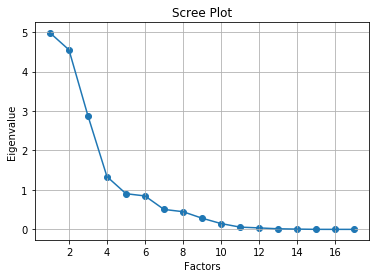

In [76]:
print(new_df_yes.columns)
factor_number_tester = FactorAnalyzer(n_factors=10, rotation="varimax") # Using number of factors = number of columns
factor_number_tester.fit(new_df_yes) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,new_df_yes.shape[1]+1),ev)
plt.plot(range(1,new_df_yes.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


In [77]:
import numpy as np
fa = FactorAnalyzer(4, rotation="varimax")
fa.fit(new_df_yes)
print(new_df_yes.columns)
print(fa.loadings_)
print(np.where(fa.loadings_>0.7))
print(fa.get_factor_variance())

Index(['Duration', 'RPE', 'SessionLoad', 'DailyLoad', 'AcuteChronicRatio',
       'ObjectiveRating', 'FocusRating', 'BestOutOfMyself', 'AcuteLoad',
       'ChronicLoad', 'SessionType_Combat', 'SessionType_Conditioning',
       'SessionType_Game', 'SessionType_Mobility/Recovery',
       'SessionType_Skills', 'SessionType_Speed', 'SessionType_Strength'],
      dtype='object')
[[ 1.43200880e-01  3.27600667e-01  7.65775318e-01  7.84834772e-02]
 [ 4.18265193e-02  3.76176036e-02  2.59926591e-01  9.01462150e-01]
 [ 2.88055547e-01  1.04037864e-01  6.09494871e-01  7.21328030e-01]
 [ 4.84199532e-01  2.48726673e-01 -7.70285030e-02  7.96160518e-01]
 [-8.85170258e-01 -8.25087730e-02 -3.14111129e-04  3.20887085e-02]
 [ 5.79711218e-01 -5.80211726e-01 -2.17102335e-01  1.42118770e-01]
 [ 2.94459623e-01 -5.85202891e-01 -2.23886171e-01  3.02325394e-01]
 [-4.25862641e-02 -7.79393697e-02  4.45587823e-01  3.17218354e-01]
 [ 8.45976639e-01  9.17721650e-02 -1.27670673e-01  4.78772447e-01]
 [ 9.18971683e-01  7

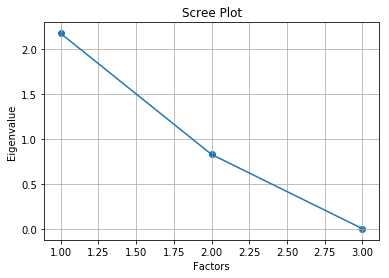

In [78]:
factor_number_tester = FactorAnalyzer(n_factors=5, rotation=None) # Using number of factors = number of columns
factor_number_tester.fit(no_without_nan_columns) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,no_without_nan_columns.shape[1]+1),ev)
plt.plot(range(1,no_without_nan_columns.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [79]:
fa = FactorAnalyzer(1,rotation = None)
fa.fit(no_without_nan_columns)
print(no_without_nan_columns.columns)
print(fa.loadings_)
print(np.where(fa.loadings_>0.5))
print(fa.get_factor_variance())

Index(['AcuteChronicRatio', 'AcuteLoad', 'ChronicLoad'], dtype='object')
[[-0.33540277]
 [ 0.94996335]
 [ 1.01634443]]
(array([1, 2], dtype=int64), array([0, 0], dtype=int64))
(array([2.04788138]), array([0.68262713]), array([0.68262713]))


[[   7.55691391   23.0733957 ]
 [ -30.22734998  -11.42708664]
 [-158.27146362  -18.27730949]
 [ -48.79360168  -29.51877699]
 [ 128.26755663  -64.95235511]
 [-166.78504199  -75.23175466]
 [-106.93871407   -7.03926006]
 [ -59.84873571    5.20641063]
 [  76.54873416   87.90409778]
 [  86.78293569   38.47677154]
 [-196.19361606    6.55338747]
 [ 252.50701435   26.88482563]
 [ -65.09259568   76.52590387]
 [ -11.39096094  -29.38844852]
 [ 209.47463114  -75.87742831]
 [ -74.99213772   51.43011988]
 [ 157.39643157   -4.34249271]]
0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
Name: PlayerID, dtype: int64
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


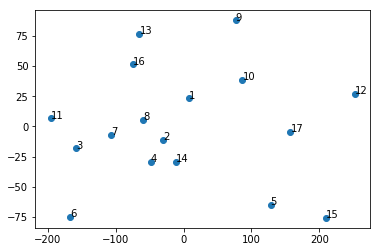

In [80]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(player_data_yes)
print(principal_components)

HORIZONTAL_OFFSET = 0
VERTICAL_OFFSET = 0

fig, ax = plt.subplots()
ax.scatter(principal_components[:, 0], principal_components[:, 1])
print(player_id_series)
for i in range(len(player_id_series)):
    print(i)
    ax.annotate(str(i + 1), (principal_components[i, 0] + HORIZONTAL_OFFSET, principal_components[i, 1] + VERTICAL_OFFSET))